---
#### Описание данных


Вам представлены данные о доходах сотрудников участка горячего проката за год, в том числе данные, описывающие специфику рабочих мест.

Доход состоит из оклада, премии, доплат и индивидуальных надбавок. Данных об их размерах не приводится, так как именно их Вам предстоит восстановить.

---

#### Задание

 - Выявите формулу дохода в целом и его составных частей
 - Проверьте, что данная формула объясняет доход с точностью до рубля
 - Выявите зависимости между составными частями дохода



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns

%matplotlib inline

Загрузим и изучим данные

In [2]:
df = pd.read_excel('salary.xlsx', parse_dates=['Месяц'])

In [6]:
df = df.rename(columns={'FIO': 'name', 
                   'Месяц': 'month', 
                   'Профессия': 'profession', 
                   'Разряд': 'category', 
                   'Оборудование': 'equipment',
                   'Вредность (балл.)': 'harm', 
                   'Объем производства': 'production_volume', 
                   'Доход': 'income'})

теперь надо найти такую величину плана чтобы выполнялось условие:

В таблицу добавим величину перевыполнения плана, если план недовыполнен примем ее за 0

In [39]:
def over(s):
    l = []
    for i in s:
        if i > 850:
            a = (i - 850)
        else:
            a = 0
        l.append(a)
    return l
df['over_production_volume'] = over(df.production_volume)

---
---
---

### Преобразуем данные для линейной регресии

In [43]:
df

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.000000,0
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.000000,0
2,Абрамов Е. Д.,2009-03-01,Уборщик,3,Пилигримовые станы,18,820,16638.000000,0
3,Абрамов Е. Д.,2009-04-01,Уборщик,3,Пилигримовые станы,18,1200,19396.411765,350
4,Абрамов Е. Д.,2009-05-01,Уборщик,3,Пилигримовые станы,18,1250,19790.470588,400
...,...,...,...,...,...,...,...,...,...
2395,Яковлев Д. И.,2009-08-01,Подручный вальцовщика,4,Прошивной стан,18,1180,21800.170588,330
2396,Яковлев Д. И.,2009-09-01,Подручный вальцовщика,4,Прошивной стан,18,1080,20885.876471,230
2397,Яковлев Д. И.,2009-10-01,Подручный вальцовщика,4,Прошивной стан,18,780,18783.000000,0
2398,Яковлев Д. И.,2009-11-01,Подручный вальцовщика,4,Прошивной стан,18,1020,20337.300000,170


In [44]:
prof = df.profession.unique()
prof

array(['Уборщик', 'Вальцовщик', 'Нагревальщик металла',
       'Оператор поста управления',
       'Контролер качества готовой продукции', 'Подручный вальцовщика',
       'Резчик горячего металла', 'Посадчик металла', 'Огнеупорщик'],
      dtype=object)

**Переведем должности в отдельные столбцы** 

Можно было наверное засунуть в цикл, но что то пошло н так, сделала кучу отдельных функций

In [45]:
df['cleaner'] = 0

def clener(s):
    l = []
    for i in s:
        if i == 'Уборщик':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['cleaner'] = clener(df.profession)
    

In [46]:
df['roller'] = 0

def roller(s):
    l = []
    for i in s:
        if i == 'Вальцовщик':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['roller'] = roller(df.profession)
    

In [47]:
df['metal_heater'] = 0

def metal_heater(s):
    l = []
    for i in s:
        if i == 'Нагревальщик металла':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['metal_heater'] = metal_heater(df.profession)

In [48]:
df['cp_operator'] = 0

def cpo(s):
    l = []
    for i in s:
        if i == 'Оператор поста управления':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['cp_operator'] = cpo(df.profession)

In [49]:
df['tci'] = 0

def tci(s):
    l = []
    for i in s:
        if i == 'Контролер качества готовой продукции':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['tci'] = tci(df.profession)

In [50]:
df['roller_assistant'] = 0

def roller_assistant(s):
    l = []
    for i in s:
        if i == 'Подручный вальцовщика':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['roller_assistant'] = roller_assistant(df.profession)

In [51]:
df['hot_metal_cutter'] = 0

def hot_metal_cutter(s):
    l = []
    for i in s:
        if i == 'Резчик горячего металла':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['hot_metal_cutter'] = hot_metal_cutter(df.profession)

In [52]:

df['metal_loader'] = 0

def metal_loader(s):
    l = []
    for i in s:
        if i == 'Посадчик металла':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['metal_loader'] = metal_loader(df.profession)

In [53]:
df['refractor'] = 0

def refractor(s):
    l = []
    for i in s:
        if i == 'Огнеупорщик':
            a = 1
        else:
            a = 0
        l.append(a)
    return l

df['refractor'] = refractor(df.profession)

In [54]:
df.head(2)

,name,month,profession,category,equipment,harm,production_volume,income,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
0,Абрамов Е. Д.,2009-01-01,Уборщик,3,Пилигримовые станы,18,580,16638.0,0,1,0,0,0,0,0,0,0,0
1,Абрамов Е. Д.,2009-02-01,Уборщик,3,Пилигримовые станы,18,790,16638.0,0,1,0,0,0,0,0,0,0,0


Проверим верность дополнения данных

In [55]:
df.groupby('profession', as_index=False) \
    .agg({'income': 'mean', 'cleaner': 'mean', 'roller': 'mean', 'metal_heater': 'mean', 'hot_metal_cutter': 'mean'})

,profession,income,cleaner,roller,metal_heater,hot_metal_cutter
0,Вальцовщик,25744.890874,0,1,0,0
1,Контролер качества готовой продукции,25175.434314,0,0,0,0
2,Нагревальщик металла,24282.386064,0,0,1,0
3,Огнеупорщик,18053.498382,0,0,0,0
4,Оператор поста управления,18929.055664,0,0,0,0
5,Подручный вальцовщика,18447.473897,0,0,0,0
6,Посадчик металла,20150.538419,0,0,0,0
7,Резчик горячего металла,18708.271639,0,0,0,1
8,Уборщик,15559.387395,1,0,0,0


Так как применяемое оборудование зависит от Професии выносить его отдельно нет необходимости

Создадим DataFrame, где будет зависимая переменная и предикторы

In [56]:
df2 = df[['income', 
          'category', 
          'harm', 
          'over_production_volume', 
          'cleaner', 
          'roller', 
          'metal_heater', 
          'cp_operator',
          'tci',
          'roller_assistant',
          'hot_metal_cutter',
          'metal_loader',
          'refractor']]

In [57]:
df2

,income,category,harm,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
0,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
1,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
2,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
3,19396.411765,3,18,350,1,0,0,0,0,0,0,0,0
4,19790.470588,3,18,400,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,21800.170588,4,18,330,0,0,0,0,0,1,0,0,0
2396,20885.876471,4,18,230,0,0,0,0,0,1,0,0,0
2397,18783.000000,4,18,0,0,0,0,0,0,1,0,0,0
2398,20337.300000,4,18,170,0,0,0,0,0,1,0,0,0


**Теперь можно применить модель линейной регресии**

Требования к регрессионнной модели
 - линейная зависимость перемнных
 - нормальное распределение остатков
 - гетероскедастичность 
 - проверка на мултьтиколлинеарность
 - нормальное распределение переменных

<AxesSubplot:>

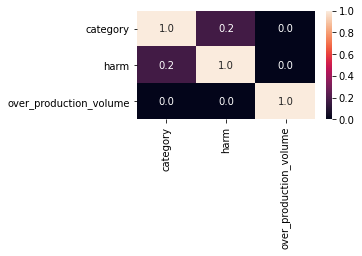

In [194]:
num_cols = ['category', 'harm', 'over_production_volume']

plt.figure(figsize=(4, 2))

sns.heatmap(df[num_cols].corr(method='spearman'), annot=True, fmt=".1f")

In [58]:
category_columns = {col: 'category' for col in ['cleaner', 
                                                'roller', 
                                               'metal_heater', 
                                               'cp_operator',
                                               'tci',
                                               'roller_assistant',
                                               'hot_metal_cutter',
                                               'metal_loader',
                                               'refractor']}  

In [59]:
result = smf.ols(formula="income ~ category + harm + over_production_volume + cleaner + roller + metal_heater + cp_operator + tci + roller_assistant + hot_metal_cutter + metal_loader + refractor", data=df2).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     7243.
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:43:14   Log-Likelihood:                -19447.
No. Observations:                2400   AIC:                         3.892e+04
Df Residuals:                    2388   BIC:                         3.899e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1656.8617    128.292     12.915      0.000    1405.286    1908.437
category                3125.7937     24.928    125.392      0.000    3076.910    3174.677
harm                     175.8482      5.667     31.029      0.000     164.735     186.961
over_production_volume    10.0262      0.089    112.967      0.000       9.852      10.200
cleaner                  936.7620     58.769     15.940      0.000     821.519    1052.005
roller                  -163.2697     68.515     -2.383      0.017    -297.625     -28.914
metal_heater            -214.6599     73.442     -2.923      0.004    -358.677     -70.643
cp_operator              -38.2065     52.127     -0.733      0.464    -140.426      64.013
tci                     -141.6411    123.141     -1.150      0.250    -383.116      99.834
roller_assistant         801.2150     55.149     14.528      0.000     693.071     909.360
hot_metal_cutter         -44.9945     83.189     -0.541      0.589    -208.124     118.135
metal_loader             342.1829     93.005      3.679      0.000     159.803     524.562
refractor                179.4734     95.157      1.886      0.059      -7.125     366.072
==============================================================================
Omnibus:                      136.063   Durbin-Watson:                   0.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              159.493
Skew:                           0.599   Prob(JB):                     2.33e-35
Kurtosis:                       3.400   Cond. No.                     2.00e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.93e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Уберем лишние предикторы

In [109]:
result = smf.ols(formula="income ~ category + harm + over_production_volume + cleaner + roller + metal_heater + roller_assistant + metal_loader", data=df2).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     9951.
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:42:59   Log-Likelihood:                -19449.
No. Observations:                2400   AIC:                         3.892e+04
Df Residuals:                    2391   BIC:                         3.897e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1683.6480    125.521     13.413      0.000    1437.506    1929.790
category                3108.8558     20.915    148.643      0.000    3067.843    3149.869
harm                     178.2943      4.721     37.767      0.000     169.037     187.552
over_production_volume    10.0262      0.089    112.924      0.000       9.852      10.200
cleaner                  935.6299     70.670     13.239      0.000     797.049    1074.211
roller                  -129.4686     77.978     -1.660      0.097    -282.380      23.442
metal_heater            -202.1009     87.050     -2.322      0.020    -372.802     -31.400
roller_assistant         790.2471     70.649     11.186      0.000     651.707     928.787
metal_loader             329.3352    108.105      3.046      0.002     117.347     541.324
==============================================================================
Omnibus:                      138.968   Durbin-Watson:                   0.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.605
Skew:                           0.605   Prob(JB):                     2.98e-36
Kurtosis:                       3.415   Cond. No.                     2.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
result = smf.ols(formula="income ~ category + harm + over_production_volume + cleaner + metal_heater + roller_assistant + metal_loader", data=df2).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.136e+04
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:43:27   Log-Likelihood:                -19450.
No. Observations:                2400   AIC:                         3.892e+04
Df Residuals:                    2392   BIC:                         3.896e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1800.9820    103.775     17.355      0.000    1597.483    2004.481
category                3089.1987     17.248    179.108      0.000    3055.377    3123.021
harm                     172.5703      3.226     53.488      0.000     166.244     178.897
over_production_volume    10.0262      0.089    112.882      0.000       9.852      10.200
cleaner                  936.1422     70.695     13.242      0.000     797.512    1074.772
metal_heater             -85.3940     51.369     -1.662      0.097    -186.125      15.337
roller_assistant         845.3992     62.376     13.553      0.000     723.083     967.715
metal_loader             416.5563     94.517      4.407      0.000     231.212     601.900
==============================================================================
Omnibus:                      139.160   Durbin-Watson:                   0.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              163.983
Skew:                           0.604   Prob(JB):                     2.46e-36
Kurtosis:                       3.423   Cond. No.                     2.00e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [111]:
result = smf.ols(formula="income ~ category + harm + over_production_volume + cleaner + roller_assistant + metal_loader", data=df2).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 income   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                 1.325e+04
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        17:43:55   Log-Likelihood:                -19452.
No. Observations:                2400   AIC:                         3.892e+04
Df Residuals:                    2393   BIC:                         3.896e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1810.7120    103.648     17.470      0.000    1607.462    2013.962
category                3091.3777     17.204    179.688      0.000    3057.641    3125.114
harm                     169.5789      2.679     63.303      0.000     164.326     174.832
over_production_volume    10.0262      0.089    112.841      0.000       9.852      10.200
cleaner                  950.6441     70.181     13.546      0.000     813.023    1088.266
roller_assistant         881.8157     58.424     15.093      0.000     767.249     996.383
metal_loader             463.9217     90.154      5.146      0.000     287.135     640.709
==============================================================================
Omnibus:                      137.103   Durbin-Watson:                   0.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              161.017
Skew:                           0.601   Prob(JB):                     1.09e-35
Kurtosis:                       3.409   Cond. No.                     1.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

***Формула дохода***

Y = 1810.7120 + 3091.3777 * category + 169.5789 * harm + 10.0262 * over_production_volume + 950.6441 * cleaner + 881.8157 * roller_assistant + 463.9217 * metal_loader

Проверим на данных например на примере 2398

In [60]:
df2

,income,category,harm,over_production_volume,cleaner,roller,metal_heater,cp_operator,tci,roller_assistant,hot_metal_cutter,metal_loader,refractor
0,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
1,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
2,16638.000000,3,18,0,1,0,0,0,0,0,0,0,0
3,19396.411765,3,18,350,1,0,0,0,0,0,0,0,0
4,19790.470588,3,18,400,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,21800.170588,4,18,330,0,0,0,0,0,1,0,0,0
2396,20885.876471,4,18,230,0,0,0,0,0,1,0,0,0
2397,18783.000000,4,18,0,0,0,0,0,0,1,0,0,0
2398,20337.300000,4,18,170,0,0,0,0,0,1,0,0,0


In [114]:
Y = 1810.7120 + 3091.3777 * 4 + 169.5789 * 18 + 10.0262 * 170 + 950.6441 * 0 + 881.8157 * 1 + 463.9217 * 0
Y

19814.9127

In [113]:
y = pd.Series(df2.income)
y[2398]

20337.3

In [115]:
Y == y[2398]

False

Проверим на данных например на примере 3

In [118]:
Y1 = 1810.7120 + 3091.3777 * 3 + 169.5789 * 18 + 10.0262 * 350 + 950.6441 * 1 + 881.8157 * 0 + 463.9217 * 0
Y1

18597.0794

In [119]:
y[3]

19396.411764705896

In [66]:
Y1 == y[3]

False

***Модель не подходит!***


---
---